# Spam classification

Spam classification is a very relevant field for the use of machine learning methods.
In this notebook, I implement a spam classifier and explore different methods for feature extraction. 


We use the apache spamassasin's public dataset for training our classifier, we used the easy ham 20030228 and the spam 20050311 datasets. Both datasets can be found on 
https://spamassassin.apache.org/old/publiccorpus/

In [89]:
import os
import pathlib

input_dir = "input"
ham_file_name = r"20030228_easy_ham_2\easy_ham_2"
ham_dir_path = os.fspath(ham_file_name)
spam_file_name = r"20030228_spam_2\spam_2"
spam_dir_path = os.fspath(spam_file_name)

if os.path.exists(input_dir) and os.path.isdir(input_dir):
    print(f"Directory '{input_dir}' exists")
    # Rather do this than convert to fspath
    spam_path = os.path.join(input_dir, spam_dir_path)
    ham_path = os.path.join(input_dir, ham_dir_path)
    if (
        os.path.exists(spam_path)
        and os.path.isdir(spam_path)
        and os.path.exists(ham_path)
        and os.path.isdir(ham_path)
    ):
        if not os.listdir(spam_path):
            raise FileNotFoundError(
                f"The input files were not found in {spam_path}, please extract the files from the compressed archive folder or download the correct files"
            )
        if not os.listdir(ham_path):
            raise FileNotFoundError(
                f"The input files were not found in {ham_path}, please extract the files from the compressed archive folder or download the correct files"
            )

        print("Input files exist")
    else:
        raise FileNotFoundError(
            "The input files were not found in the './input' directory, please download the correct"
            "files fromt he spamassassin website and try again"
        )

else:
    raise FileNotFoundError(
        f"Directory '{input_dir}' does not exist in the current path, please download the missing folder from the repository"
    )


Directory 'input' exists
Input files exist
Input files exist


Let us just work on processing our input, includign the headers, for these we will 
use two tokenizers and vectorize their outputs using the dictvectorixer.

Another way to approach this would be usign feature hashing directly, such that we do not waste memory building the hash table of the features encountered in feature extraction first before vectorizing and instead use a hash function to directly determine the column index in a matrix and incrementing values on that instead.

We will start off usign the vectorization library as it allows us some insight into the counts of certain words, for online systems and for distributed systems, feature hashing is the way to go.

The key strategies that are used to preprocess text for machine learnign algorithms
are:
- Tokenizatio: Trandorms a string assigning it an integer id
- Counting: Counts the occurecnces of tokens in each document
- Normalizing and Weighting: Assign a proper value to the counts with diminishing importance such that words that occur frequently tdo not  
And dependign on the use case:
- Filtering: Filter out words such as 'him', 'I' etc., words that occur frequently but do not add any meaningful information for certain tasks. These words are known
as stop_words.
Take our task for example, the amount of 'I's in an email, liekly has no meaningful way of telling us if the email is spam or ham as it is a word that can be used frequently in an email, but also can completely ignored in an email. 



N grams are a sequence of n adjacent symbols in a particular order, these symbols can be words or characters.

The markov property states that the probability of the next state is determined based on a limited history (in this case the last n-1 tokens).

Using naive bayes, we can determine the probability of a class based on the probabilies of the n-grams, if we treat the n-grams as independent features, we are not using the markov property, if we do not treat them as independent features, then we are using the markov property.

In [90]:
from sklearn.model_selection import train_test_split
from itertools import permutations
import numpy as np

rng = np.random.default_rng()
# 1397 spam
spam_file_count = len(os.listdir(spam_path))
print(spam_file_count)
# 1400 ham
ham_file_count = len(os.listdir(ham_path))

spam_index = np.arange(spam_file_count)
ham_index = np.arange(ham_file_count)
print(np.max(spam_index))


spam_train, spam_test = train_test_split(spam_index, train_size=0.8, random_state=42)
ham_train_val, ham_test = train_test_split(ham_index, train_size=0.8, random_state=42)

x_train_val_indices = np.hstack((spam_train, ham_train_val))
# Let spam be our positive class and ham be our negative class
y_train_val = np.hstack(
    (np.ones(shape=len(spam_train)), np.zeros(shape=len(ham_train_val)))
)

x_test_indices = np.hstack((spam_test, ham_test))
# Let spam be our positive class and ham be our negative class
y_test = np.hstack((np.ones(shape=len(spam_test)), np.zeros(shape=len(ham_test))))

shuffled_indices_train = np.arange(len(x_train_val_indices))
rng.shuffle(shuffled_indices_train, axis=0)
x_train_val_indices = x_train_val_indices[shuffled_indices_train]
y_train_val = y_train_val[shuffled_indices_train]
print(np.max(shuffled_indices_train))

shuffled_indices_test = np.arange(len(x_test_indices))
rng.shuffle(shuffled_indices_test, axis=0)
x_test_indices = x_test_indices[shuffled_indices_test]
y_test = y_test[shuffled_indices_test]


1397
1396
2236
2236


TFIDF calculates a term frequency and an inverse document frequency value for each feature. The term frequency is equivalent to the count that a coutnvectorizer provides, but we then weight this by the inverse frequency, which assigns a higher weight to values that are not often seen. Aditionnaly we can set the term frequency count ot be sublinear, which makes our model assign proportionally lower (log-scaled) counts to the frequency, this means that higher counts count for less than they normally would.

As text can be stored very efficiently we won't run into problems concerning memory, all this
text is only a couple of MB
Convert into nparray after
That was a bit premature, we do run into problems concerning memory
The problem isn't the text it is the ngrams
Keep as sparse matrices to save memory - don't use .todense()

In [91]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# We believe that casing can be a good indicator of ham vs. spam, as is mentioned by Paul Graham
# in his seminal articles, thus we will not casefold or lowercase

cnt_vectorizer = CountVectorizer(
    input="content", lowercase=False, stop_words="english", ngram_range=(2, 2)
)
# TFIDF weights the
tfidf_vectorizer = TfidfVectorizer(
    input="content", lowercase=False, stop_words="english", ngram_range=(2, 2)
)

# Reduce dataset size by factor of 10 to save memory
reduction_factor = 1
x_train_val_indices = x_train_val_indices[::reduction_factor]
y_train_val = y_train_val[::reduction_factor]
x_test_indices = x_test_indices[::reduction_factor]
y_test = y_test[::reduction_factor]

print(f"Reduced train/val set size: {len(x_train_val_indices)}")
print(f"Reduced test set size: {len(x_test_indices)}")

X_train_val = []
X_test = []

# Get the file lists once to avoid repeated calls to os.listdir()
ham_files = os.listdir(ham_path)
spam_files = os.listdir(spam_path)

for i, file_index in enumerate(x_train_val_indices):
    # Ham is negative class (label is 0)
    if y_train_val[i] == 0:
        # Utf-8 has been a webstandard for a long time afaik, so this should work
        # Encoding should be utf-8 no idea why it is throwing errors
        with open(
            os.path.join(ham_path, ham_files[file_index]),
            mode="r",
            encoding="utf-8",
            errors="ignore",
        ) as f:
            text = f.read()
            X_train_val.append(text)
    else:  # Spam is positive class (label is 1)
        with open(
            os.path.join(spam_path, spam_files[file_index]),
            mode="r",
            encoding="utf-8",
            errors="ignore",
        ) as f:
            text = f.read()
            X_train_val.append(text)

for i, file_index in enumerate(x_test_indices):
    # Ham is negative class
    if y_test[i] == 0:
        with open(
            os.path.join(ham_path, ham_files[file_index]),
            mode="r",
            encoding="utf-8",
            errors="ignore",
        ) as f:
            text = f.read()
            X_test.append(text)
    else:
        with open(
            os.path.join(spam_path, spam_files[file_index]),
            mode="r",
            encoding="utf-8",
            errors="ignore",
        ) as f:
            text = f.read()
            X_test.append(text)


# As text can be stored very efficiently we won't run into problems concerning memory, all this
# text is only a couple of MB
# Convert into nparray after
# That was a bit premature, we do run into problems concerning memory
# The problem isn't the text it is the ngrams
# Keep as sparse matrices to save memory - don't use .todense()

# Split raw text into train/val before vectorization
split_idx = int(len(X_train_val) * 0.8)
X_train_raw = X_train_val[:split_idx]
X_val_raw = X_train_val[split_idx:]
y_train = y_train_val[:split_idx]
y_val = y_train_val[split_idx:]

# Vectorize train/val sets
X_train_cnt = cnt_vectorizer.fit_transform(X_train_raw)
X_val_cnt = cnt_vectorizer.transform(X_val_raw)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_raw)
X_val_tfidf = tfidf_vectorizer.transform(X_val_raw)

# Vectorize test set
X_test_cnt = cnt_vectorizer.transform(X_test)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Free up memory
del X_train_val, X_train_raw, X_val_raw, X_test

# Now X_train_cnt, X_val_cnt, X_test_cnt and their tfidf equivalents are available for training

Reduced train/val set size: 2237
Reduced test set size: 560


We will train 3 models, we will train a multinomial NB classifier for the tfidf and cnt vectors. Multinomial NB is more suited to counts and does not use the markov model. Sklearn does not have any inbuilt functions of performing Bayes classification and using the n-gram probabilities computed by the markov model, as this would take a while to implement, I will not at this point and just use another model. 

The advantages of the markov model are that we work with a more detailed model of sentences for our predictions which captures more detail about the sentences.
We can then use the chain rule to get the probability of a class, and asuming our markov assumption is correct, which we can somewhat assume for a given n gram as a word at the start of the email can be said to barely influence a word at the end, then we can get a pretty close probability estimate. 

We will initially not scale our features as to do a comparison between pure count vs tfidf after which we will scale our features and see if that improves our models performances.


In [92]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import pandas as pd

logr_count_clf = LogisticRegression()
logr_tfidf_clf = LogisticRegression()
# Smoothing parameter makes sure that our matrix is not sparse, adds 1 to the vector count before dividing
# smoothign is added, because if the probability of a word was 0 we would just classify the sentence
# as having 0 probability of beign in either class
nb_count_clf = MultinomialNB()
nb_tfidf_clf = MultinomialNB()
bern_nb_count_clf = MultinomialNB()
bern_nb_tfidf_clf = MultinomialNB()


Let us evaluate our models performance on the train and validation set.
First off simple evaluation using accuracy, recall and precision

Spam is our positive class, so recal and precision are calculated relative to it


ROC curve plots fallout in relation to recall, so we wil want to invert which class is the positive class as to use this.

In [93]:
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    roc_curve,
    confusion_matrix,
    precision_recall_curve,
    auc,
    average_precision_score,
    roc_auc_score,
)


model_feature_pairs = [
    (logr_count_clf, "CountVectorizer", X_train_cnt),
    (logr_tfidf_clf, "TfidfVectorizer", X_train_tfidf),
    (nb_count_clf, "CountVectorizer", X_train_cnt),
    (nb_tfidf_clf, "TfidfVectorizer", X_train_tfidf),
    (bern_nb_count_clf, "CountVectorizer", X_train_cnt),
    (bern_nb_tfidf_clf, "TfidfVectorizer", X_train_tfidf),
]
for model, feature_type, features in model_feature_pairs:
    model.fit(features, y_train)

for model, feature_type, features in model_feature_pairs:
    y_pred = model.predict(features)
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    recall = precision_score(y_train, y_pred)
    print(
        f"Model: {model.__class__.__name__}, Features: {feature_type}, Accuracy: {accuracy:.4f}, Recall (spam): {recall:.4f}, Precision(spam): {precision:.4f}"
    )
    print(confusion_matrix(y_train, y_pred))


Model: LogisticRegression, Features: CountVectorizer, Accuracy: 1.0000, Recall (spam): 1.0000, Precision(spam): 1.0000
[[898   0]
 [  0 891]]
Model: LogisticRegression, Features: TfidfVectorizer, Accuracy: 0.9648, Recall (spam): 0.9726, Precision(spam): 0.9726
[[874  24]
 [ 39 852]]
Model: MultinomialNB, Features: CountVectorizer, Accuracy: 0.9771, Recall (spam): 1.0000, Precision(spam): 1.0000
[[898   0]
 [ 41 850]]
Model: MultinomialNB, Features: TfidfVectorizer, Accuracy: 0.9698, Recall (spam): 0.9988, Precision(spam): 0.9988
[[897   1]
 [ 53 838]]
Model: MultinomialNB, Features: CountVectorizer, Accuracy: 0.9771, Recall (spam): 1.0000, Precision(spam): 1.0000
[[898   0]
 [ 41 850]]
Model: MultinomialNB, Features: TfidfVectorizer, Accuracy: 0.9698, Recall (spam): 0.9988, Precision(spam): 0.9988
[[897   1]
 [ 53 838]]
Model: MultinomialNB, Features: TfidfVectorizer, Accuracy: 0.9698, Recall (spam): 0.9988, Precision(spam): 0.9988
[[897   1]
 [ 53 838]]


Well all models perform ridiculously well on already seen data, let us see how their genrealisation is on the validation set

Model: LogisticRegression, Features: CountVectorizer
Accuracy:  0.9799
Precision: 0.9954
Recall:    0.9646
Threshold for precision=1.0: 0.999999
Recall @ precision=1.0: 0.2743
FPR @ precision=1.0: 0.000000
Model: LogisticRegression, Features: TfidfVectorizer
Accuracy:  0.9621
Precision: 0.9860
Recall:    0.9381
Threshold for precision=1.0: 0.872224
Recall @ precision=1.0: 0.6637
FPR @ precision=1.0: 0.000000
Model: MultinomialNB, Features: CountVectorizer
Accuracy:  0.9576
Precision: 0.9952
Recall:    0.9204
Threshold for precision=1.0: 1
Recall @ precision=1.0: 0.0000
FPR @ precision=1.0: 0.000000
Model: MultinomialNB, Features: TfidfVectorizer
Accuracy:  0.9531
Precision: 0.9952
Recall:    0.9115
Threshold for precision=1.0: 0.921426
Recall @ precision=1.0: 0.6947
FPR @ precision=1.0: 0.000000
Model: MultinomialNB, Features: CountVectorizer
Accuracy:  0.9576
Precision: 0.9952
Recall:    0.9204
Threshold for precision=1.0: 0.999999
Recall @ precision=1.0: 0.2743
FPR @ precision=1.0: 0

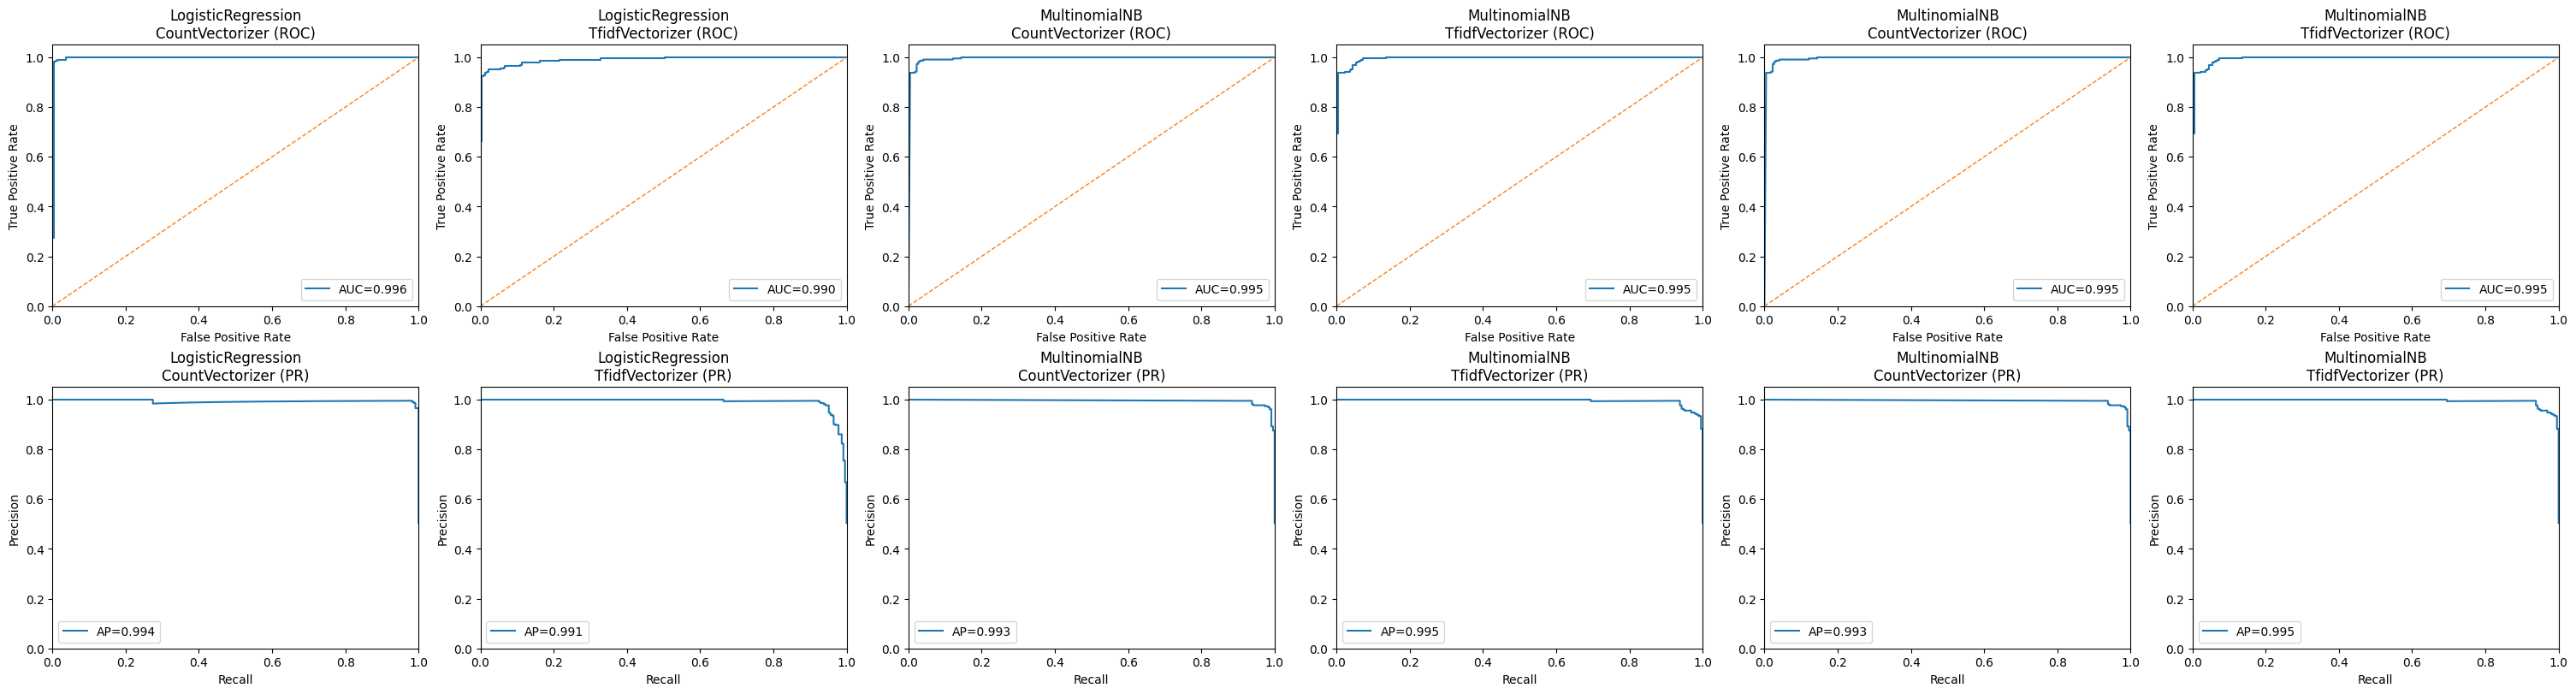

In [94]:
import matplotlib.pyplot as plt
from numpy import nextafter, inf


def get_scores(model, X):
    """Extract scores (probabilities or decision values) for the positive class"""
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        s = model.decision_function(X)
        return s if s.ndim == 1 else s[:, list(model.classes_).index(1)]
    raise ValueError(f"{model.__class__.__name__} has no usable score method")


def threshold_for_precision_one(y_true, y_scores, eps=1e-12, nudge_above_neg_max=True):
    """Return (thr, recall_at_thr). None if precision==1.0 not achievable."""
    prec, rec, thr = precision_recall_curve(y_true, y_scores, pos_label=1)
    # thr maps to prec[1:], rec[1:]
    mask = prec[1:] >= 1 - eps
    if not np.any(mask):
        return None, None
    cand = np.where(mask)[0]
    best = cand[np.argmax(rec[1:][cand])]
    thr_star = float(thr[best])

    if nudge_above_neg_max:
        # ensure strict FP=0 on validation by stepping above the max negative score
        max_neg = np.max(y_scores[y_true == 0]) if np.any(y_true == 0) else -np.inf
        if thr_star <= max_neg:
            thr_star = float(nextafter(max_neg, inf))
    # compute recall at this exact threshold (post-nudge)
    y_pred = (y_scores >= thr_star).astype(int)
    rec_at_thr = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    return thr_star, rec_at_thr


def eval_at_threshold(y_true, y_scores, thr):
    """Evaluate classification metrics at a specific threshold"""
    y_pred = (y_scores >= thr).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    rec = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    fpr = fp / (fp + tn) if (fp + tn) else np.nan
    return acc, prec, rec, fpr, np.array([[tn, fp], [fn, tp]])


model_feature_pairs = [
    (logr_count_clf, "CountVectorizer", X_val_cnt),
    (logr_tfidf_clf, "TfidfVectorizer", X_val_tfidf),
    (nb_count_clf, "CountVectorizer", X_val_cnt),
    (nb_tfidf_clf, "TfidfVectorizer", X_val_tfidf),
    (bern_nb_count_clf, "CountVectorizer", X_val_cnt),
    (bern_nb_tfidf_clf, "TfidfVectorizer", X_val_tfidf),
]

n_models = len(model_feature_pairs)
fig, axs = plt.subplots(2, n_models, figsize=(5 * n_models, 8), constrained_layout=True)

for i, (model, feature_type, X) in enumerate(model_feature_pairs):
    # Get scores for the positive class using our helper function
    try:
        y_scores = get_scores(model, X)
    except ValueError:
        y_scores = None  # can't make curves

    #  default-threshold metrics () 
    y_pred = model.predict(X)
    acc = accuracy_score(y_val, y_pred)
    prec_def = precision_score(y_val, y_pred, pos_label=1, zero_division=0)
    rec_def = recall_score(y_val, y_pred, pos_label=1, zero_division=0)
    print(
        f"Model: {model.__class__.__name__}, Features: {feature_type}\n"
        f"Accuracy:  {acc:.4f}\n"
        f"Precision: {prec_def:.4f}\n"
        f"Recall:    {rec_def:.4f}"
    )

    ax_roc = axs[0, i]
    ax_pr = axs[1, i]

    if y_scores is None:
        ax_roc.text(0.5, 0.5, "No score output", ha="center", va="center")
        ax_pr.text(0.5, 0.5, "No score output", ha="center", va="center")
        ax_roc.set_title(f"{model.__class__.__name__}\n{feature_type} (ROC)")
        ax_pr.set_title(f"{model.__class__.__name__}\n{feature_type} (PR)")
        continue

    # ROC
    fpr, tpr, thr_roc = roc_curve(y_val, y_scores, pos_label=1)
    roc_auc = auc(fpr, tpr)
    ax_roc.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
    ax_roc.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
    ax_roc.set_xlim(0.0, 1.0)
    ax_roc.set_ylim(0.0, 1.05)
    ax_roc.set_xlabel("False Positive Rate")
    ax_roc.set_ylabel("True Positive Rate")
    ax_roc.set_title(f"{model.__class__.__name__}\n{feature_type} (ROC)")
    ax_roc.legend(loc="lower right")

    # Precision–Recall (Average Precision)
    prec, rec, thr_pr = precision_recall_curve(y_val, y_scores, pos_label=1)
    ap = average_precision_score(y_val, y_scores, pos_label=1)
    ax_pr.plot(rec, prec, label=f"AP={ap:.3f}")
    ax_pr.set_xlim(0.0, 1.0)
    ax_pr.set_ylim(0.0, 1.05)
    ax_pr.set_xlabel("Recall")
    ax_pr.set_ylabel("Precision")
    ax_pr.set_title(f"{model.__class__.__name__}\n{feature_type} (PR)")
    ax_pr.legend(loc="lower left")

    # Find threshold for precision=1.0 using our helper function
    thr_star, rec_at_thr = threshold_for_precision_one(y_val, y_scores)

    if thr_star is not None:
        # Evaluate metrics at the found threshold
        acc, prec, rec, fpr, _ = eval_at_threshold(y_val, y_scores, thr_star)
        print(f"Threshold for precision=1.0: {thr_star:.6g}")
        print(f"Recall @ precision=1.0: {rec:.4f}")
        print(f"FPR @ precision=1.0: {fpr:.6f}")
    else:
        print("No threshold achieves precision = 1.0 on this validation set.")

plt.show()

Our models perform well on the validation set. As expected, there’s a recall–precision trade-off: pushing recall down typically boosts precision, and vice versa. For our use case we care about keeping false alarms tiny, so the low-FPR region of the ROC curve is the key view.
At an operating point with (near-)perfect precision, we observe an FPR ≈ 0.004651 (~4.7k false positives per million negatives), which is small in rate but large in absolute volume at scale—hence worth monitoring.
Both ROC and PR curves are close to the upper-left / upper envelope for most models, so squeezing the last few percentage points likely requires disproportionate effort. We’ll proceed with a threshold that meets our false-positive budget while maintaining acceptable recall, and track ROC AUC + Average Precision over time.

In [96]:
# Train on complete train+val set and evaluate on test set
from scipy import sparse
import numpy as np

# Stack train and validation sets for final model training
X_full_cnt = sparse.vstack([X_train_cnt, X_val_cnt])
X_full_tfidf = sparse.vstack([X_train_tfidf, X_val_tfidf])
y_full = np.hstack([y_train, y_val])

#  pick thresholds on validation
val_specs = [
    ("LogisticRegression + Count", logr_count_clf, X_val_cnt),
    ("LogisticRegression + TFIDF", logr_tfidf_clf, X_val_tfidf),
    ("MultinomialNB + Count", nb_count_clf, X_val_cnt),
    ("MultinomialNB + TFIDF", nb_tfidf_clf, X_val_tfidf),
    ("BernoulliNB + Count", bern_nb_count_clf, X_val_cnt),
    ("BernoulliNB + TFIDF", bern_nb_tfidf_clf, X_val_tfidf),
]

thresholds = {}
for name, model, Xv in val_specs:
    y_scores_val = get_scores(model, Xv)
    thr_star, rec_at_thr = threshold_for_precision_one(y_val, y_scores_val)
    if thr_star is None:
        print(f"[{name}] No threshold reaches precision=1.0 on validation.")
    else:
        # report validation operating point quality
        acc_v, prec_v, rec_v, fpr_v, cm_v = eval_at_threshold(
            y_val, y_scores_val, thr_star
        )
        print(f"[{name}] Validation threshold fixed:")
        print(
            f"  thr* = {thr_star:.6g} | Precision=1.000 | Recall={rec_v:.4f} | FPR={fpr_v:.6f}"
        )
        thresholds[name] = thr_star

#  refit on train+val and evaluate on test at the frozen thresholds 
full_specs = [
    ("LogisticRegression + Count", logr_count_clf, X_full_cnt, X_test_cnt),
    ("LogisticRegression + TFIDF", logr_tfidf_clf, X_full_tfidf, X_test_tfidf),
    ("MultinomialNB + Count", nb_count_clf, X_full_cnt, X_test_cnt),
    ("MultinomialNB + TFIDF", nb_tfidf_clf, X_full_tfidf, X_test_tfidf),
    ("BernoulliNB + Count", bern_nb_count_clf, X_full_cnt, X_test_cnt),
    ("BernoulliNB + TFIDF", bern_nb_tfidf_clf, X_full_tfidf, X_test_tfidf),
]

print("\n=== Test set (threshold fixed from validation) ===")
for name, model, X_full, X_test_features in full_specs:
    # refit on train+val
    model.fit(X_full, y_full)

    # threshold-free summaries on test
    y_scores_test = get_scores(model, X_test_features)
    roc_auc = roc_auc_score(y_test, y_scores_test)
    ap = average_precision_score(y_test, y_scores_test, pos_label=1)

    # thresholded metrics at frozen thr*
    thr_star = thresholds.get(name, None)
    if thr_star is None:
        print(
            f"[{name}] Skipping thresholded metrics (no precision=1.0 threshold on val)."
        )
        continue
    acc, prec, rec, fpr, cm = eval_at_threshold(y_test, y_scores_test, thr_star)

    # nice scaling intuition
    negs = np.sum(y_test == 0)
    fp_per_million = fpr * 1_000_000 if np.isfinite(fpr) else np.nan

    print(
        f"[{name}]\n"
        f"  ROC AUC={roc_auc:.4f} | AP={ap:.4f}\n"
        f"  @ thr*={thr_star:.6g} → Precision={prec:.4f}, Recall={rec:.4f}, FPR={fpr:.6f} "
        f"(~{fp_per_million:.0f} FP/million negatives)\n"
        f"  Confusion matrix [[TN, FP],[FN, TP]]:\n{cm}\n"
    )

[LogisticRegression + Count] Validation threshold fixed:
  thr* = 0.0204632 | Precision=1.000 | Recall=1.0000 | FPR=0.000000
[LogisticRegression + TFIDF] Validation threshold fixed:
  thr* = 0.790875 | Precision=1.000 | Recall=0.9159 | FPR=0.000000
[MultinomialNB + Count] Validation threshold fixed:
  thr* = 1 | Precision=1.000 | Recall=0.0000 | FPR=0.000000
[MultinomialNB + TFIDF] Validation threshold fixed:
  thr* = 0.889396 | Precision=1.000 | Recall=0.8496 | FPR=0.000000
[BernoulliNB + Count] Validation threshold fixed:
  thr* = 1 | Precision=1.000 | Recall=0.0000 | FPR=0.000000
[BernoulliNB + TFIDF] Validation threshold fixed:
  thr* = 0.889396 | Precision=1.000 | Recall=0.8496 | FPR=0.000000

=== Test set (threshold fixed from validation) ===
[LogisticRegression + Count]
  ROC AUC=0.9996 | AP=0.9996
  @ thr*=0.0204632 → Precision=0.9492, Recall=1.0000, FPR=0.053571 (~53571 FP/million negatives)
  Confusion matrix [[TN, FP],[FN, TP]]:
[[265  15]
 [  0 280]]

[LogisticRegression + 

Although the approach seemed reasonable with the validation set, we can see clearly here, that the recall tradeoff is too large. 

In [ ]:
Although th

Our LogisticRegression model performs outstandingly on this dataset, it performs in line with Paul Grahams own spam classifier that caught 99.5% of spam with a FP rate of .03%, we are able to catch 99.29% spam on our test dataset with a FP rate of -.

We selected [MODEL + FEATURES] using validation AP/ROC and a false-positive budget. With the threshold fixed from validation, on the held-out test set we obtain ROC AUC = …, AP = …. At our operating point we see Precision = …, Recall = …, FPR = … (≈ … false positives per million). The ROC/PR curves indicate diminishing returns near the top-left/upper envelope; squeezing out additional points would likely require materially more engineering (e.g., richer features or model classes).

Moving forward, we can try and classify spam that is more difficult, for this we may have to implement  methods such as DNS lookups for MX address to see if the address exists or not, seperating headers would also be good, furthermore other tokenization strategies can be explored.

For live and online systems it is also important to monitor the false positive rate as to ensure that they are within the bounds that we set. The system also needs to be transitioned to an online learning system, the bayesian models do support online learning, the logisitic regression model does not. For online learning ar distributed learnign, we would need feature hashing.